# Olivine Diffusion 3

(c) Charles Le Losq

To continue the course, we will work directly on real data. In the following cell I will show you how to load a dataset from a CSV file. Then we determine the X-Y data on which we will work and plot them.

Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')
Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')


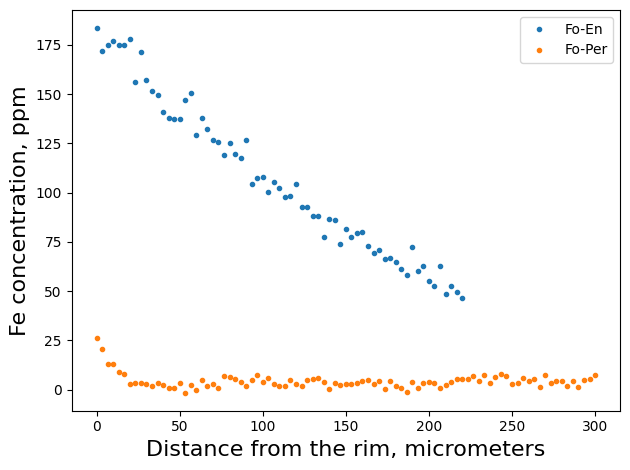

In [39]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
import scipy
from scipy.optimize import curve_fit

from scipy.special import erfc
#
# Loading the data
#
data_1400C_192h_FoEn = pd.read_csv("./data/16C_ICP1_1400C_axisC_192h_FoEn.csv")
print(data_1400C_192h_FoEn.columns)
data_1400C_192h_FoPer = pd.read_csv("./data/16B_ICP2_1400C_axisC_192h_FoPer.csv")
print(data_1400C_192h_FoPer.columns)

#
# The data we want to fit
#
t_exp = 192.0*3600
x_obs_1 = data_1400C_192h_FoEn.Distance.values
y_obs_1 = data_1400C_192h_FoEn.Fe_ppm_m57.values
ese_obs_1 = 6.0*np.ones(len(x_obs_1))

#
# Plotting the data
#
plt.plot(x_obs_1,y_obs_1,".",label="Fo-En")
plt.plot(data_1400C_192h_FoPer.Distance, data_1400C_192h_FoPer.Fe_ppm_m57, ".", label="Fo-Per")
plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

Now we solve the problem using the methods we know. I start with a global search for a solution using the differential evolution algorithm, then once it founds a good solution, I use `curve_fit` to refine the solution and get access to the covariance matrix.

Optimal values:
[-13.72458456 181.65279109  23.33726779]
Error bars:
[0.06948157 1.84691946 8.28835481]


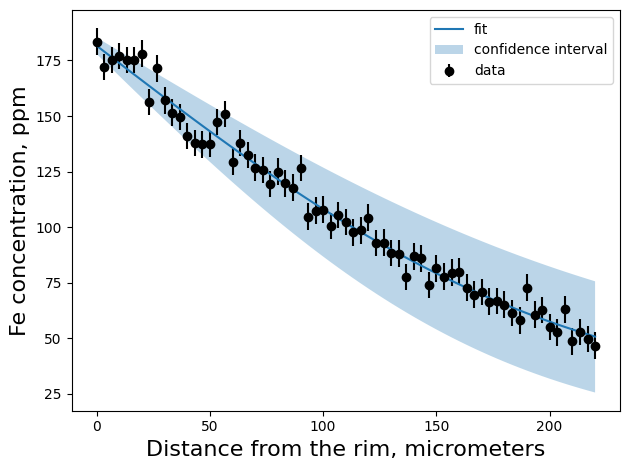

In [40]:
def forward_model(x, D, crim, ccore):
    """This is the foward model: solution in 1D of Fick diffusion
    
    Parameters
    ----------
    x : 1d array
        the distance in microns
    D : float
        the diffusion coefficient, in log10 m2 s-1
    c0 : float
        the concentration at the border
        
    Returns
    -------
    c(x) : array
        the array of the concentrations at x
    """
    t = 192.0*3600 # time is defined here
    return (crim-ccore)*erfc(x*1e-6/(2*np.sqrt(10**D*t))) + ccore

from scipy.optimize import differential_evolution # we import the method here

def least_squares_objective(list_of_parameters, x, y, yerr=1.0):
    """the least square objective function"""
    model_values = forward_model(x, list_of_parameters[0], list_of_parameters[1], list_of_parameters[2])
    criterion = np.sum((y-model_values)**2/yerr**2) # ponderated least squares criterion
    return criterion

# we need to define a search space
# in the form of a list, containing sub-mlists of lower and upper bounds for the parameters
search_space = [[-30., 0.], # D bounds
                [0.0, 200.], #crim
                [0.0, 200.]] #ccore

# the differential_evolution expects that the least_squares_objective
# function takes the parameters as the first argument. 
# Any additional inputs are provided in a tuple via the args argument
# this is pretty standard in scipy
# the minimize() function (actually behind curve_fit) uses the same API
result_LS = differential_evolution(least_squares_objective, # objective function
                                   search_space, # search space (list of [lb, hb] per parameter)
                                   args=(x_obs_1,
                                         y_obs_1,
                                         ese_obs_1))

# getting the "best" parameters found by the differential_evolution search
pini = result_LS.x

#
# Refinement : using curve_fit with the solution returned by differential_evolution as a starting point
#
popt, pcov = curve_fit(forward_model, x_obs_1, y_obs_1, sigma=ese_obs_1, p0=pini)
perr = np.sqrt(np.diag(pcov))

# model predictions
y_calc = forward_model(x_obs_1, *popt)
# confidence interval (95 % = 2 sigma)
y_lower_ci = forward_model(x_obs_1, *popt-2*perr)
y_upper_ci = forward_model(x_obs_1, *popt+2*perr)

# now a figure representing the data and the fit
plt.figure()

# plot data
plt.errorbar(x_obs_1, y_obs_1, yerr=ese_obs_1, fmt="ko", label="data")

# plot model
plt.plot(x_obs_1, forward_model(x_obs_1, *popt), label="fit")

# add a plot of the confidence interval
plt.fill_between(x_obs_1, y_lower_ci, y_upper_ci,
                 alpha=0.3, label="confidence interval")

# add labels and legend, tighten layout
plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

# print the optimal values and the error bars
print("Optimal values:")
print(popt)
print("Error bars:")
print(np.sqrt(np.diag(pcov)))

The uncertainty envelop looks weird. Wait, let's check how much of the data points fall within the error bar envelop. We plotted the 2-sigma 95% uncertainty envelop, so we should have around 95% of the data points falling within the blue region.

In [41]:
# check if 95% of the data points fall within the 2 sigma interval

# we create a mask: it will be a vector of True values if the conditions
# is met, False if it is not.
# then we count the True values and calculate their fraction 
mask = (y_obs_1 > y_calc-y_lower_ci) & (y_obs_1 < y_calc+y_upper_ci)
print("Fraction of data points within 2 sigma:", np.sum(mask)/len(mask))


Fraction of data points within 2 sigma: 1.0


All our data points fall within the blue envelop. We overestimate the model errors here. Something is not right. 

Wait, we did not take into account for covariance between the parameters. It actually may be high. We first check for this by plotting the covariance matrix in colors, with the values in each cell.

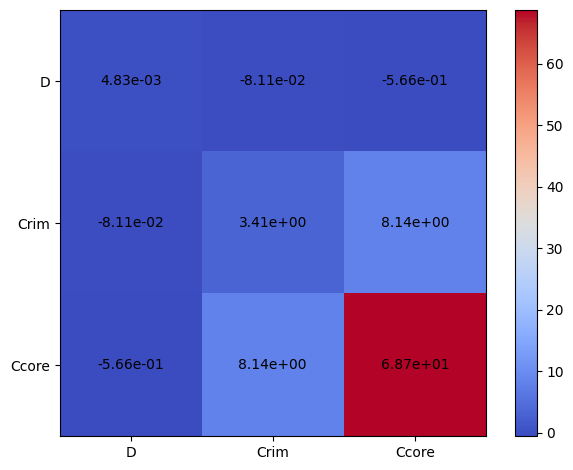

In [42]:
# plot the covariance matrix with color code
plt.figure()
plt.imshow(pcov, cmap="coolwarm")
# add the values in the cells
for i in range(3):
    for j in range(3):
        plt.text(i,j, f"{pcov[i,j]:.2e}", ha="center", va="center", color="black")  
# add labels
plt.xticks([0,1,2], ["D", "Crim", "Ccore"])
plt.yticks([0,1,2], ["D", "Crim", "Ccore"])
plt.colorbar()
plt.tight_layout()

OK, we observe an important covariance between parameters. We cannot neglect it. We need to take it into account in the error bars. We can do that by using the covariance matrix.

The covariance matrix is a square matrix of the same size as the number of parameters. The diagonal contains the variance of each parameter, and the off-diagonal elements contain the covariance between the parameters. The covariance matrix is the inverse of the Hessian matrix of the least squares objective function. The Hessian matrix is the matrix of second derivatives of the least squares objective function. It is a measure of the curvature of the least squares objective function around the optimal values of the parameters.

You can use a formula to propagate the errors on and the covariances between the parameters when calculating the confidence intervals for the values of Y. It involves calculating derivatives, and could become quite complex. Fortunately, libraries such as `uncertainties` do that for you, see the docs [here](https://pythonhosted.org/uncertainties/user_guide.html). I advise using them. 

Let's use `uncertainties` below. Beware that we need to redefine a forward_model function that uses the `uncertainties.unumpy` module for the `erfc` and the `sqrt` functions. We will call it `forward_model_unumpy()`. 

*(note: during the class I did a code a bit more messy and less strict. I was injecting the error bars into forward_model to get yerr2, and not using the unumpy.correlated_values object. This is equivalent but not the best method. I advise using the code below, it is cleaner. It uses the correlated_values object during the forward_model computation. However, it involves creating a second forward_model function using the unumpy.erfc and unumpy.sqrt functions...)*

In [43]:
import uncertainties
from uncertainties import unumpy

def forward_model_unumpy(x, D, crim, ccore):
    """This is the foward model: solution in 1D of Fick diffusion
    
    Parameters
    ----------
    x : 1d array
        the distance in microns
    D : float
        the diffusion coefficient, in log10 m2 s-1
    c0 : float
        the concentration at the border
        
    Returns
    -------
    c(x) : array
        the array of the concentrations at x
    """
    t = 192.0*3600 # time is defined here
    return (crim-ccore)*unumpy.erfc(x*1e-6/(2*unumpy.sqrt(10**D*t))) + ccore

from scipy.optimize import differential_evolution # we import the method here

# we create a list of uncertainties
popt_un = uncertainties.correlated_values(popt, pcov)

# we can now use the forward model with uncertainties
y_unumpy = forward_model(x_obs_1, *popt_un)
y_calc2 = unumpy.nominal_values(y_unumpy) # we get the nominal value = the prediction
yerr2 = 2*unumpy.std_devs(y_unumpy) # 2-sigma error bars

# create a figure
plt.figure()

# plotting the data
plt.errorbar(x_obs_1, y_obs_1, yerr=ese_obs_1, fmt="ko", label="data")

# plotting the 
plt.plot(x_obs_1, y_calc2, label="fit")
plt.fill_between(x_obs_1, y_calc2-yerr2, y_calc2+yerr2, alpha=0.3, label="confidence interval")
plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

TypeError: loop of ufunc does not support argument 0 of type AffineScalarFunc which has no callable sqrt method

Our error bars now look small. We can check if they are OK. Indeed, if they are, 95% of the data points should fall within the 2-sigma error bars. Let's check this.

In [44]:
# check if 95% of the data points fall within the 2 sigma interval

# we create a mask: it will be a vector of True values if the conditions
# is met, False if it is not.
# then we count the True values and calculate their fraction 
mask = (y_obs_1 > y-2*yerr) & (y_obs_1 < y+2*yerr)
print("Fraction of data points within 2 sigma:", np.sum(mask)/len(mask))


Fraction of data points within 2 sigma: 0.8208955223880597


Ah. Our confidence intervals are a little bit too small. Maybe our estimates on the error affecting the data points is bad. Maybe the optimization method is not appropriate... In any cases, something is not going well... Maybe we need to calculate the error bars in a different way. 

The problem we observed occurs frequently when trying to estimate errors on parameters using the covariance matrix. The obtained errors are not always reliable, or in other terms, they are very often not the good ones because the shape of the objective function can be far from an ideal multivariate Gaussian (go back to the previous notebook if you need to be convinced for this problem). Plus, if you are using an objective function different from least squares, well you don't have access to the covariance function... it does not exist!

To circumvent this problem, we can use different methods. Among those, two are interesting:

- Bootstrapping allows you to estimate parameters error from the statistical sampling of your data
- Markov-Chain Monte Carlo (MCMC) is another interesting method, which further allows you to use prior estimates for your parameters

### Bootstrapping (non-parametric)

The idea is to generate n subsamples (with replacement) from our dataset, fit them, and estimate the errors on the parameters based on those n fits.

Efron (1979) proved that, given you have sufficient samples, this method works very well and allows retrieving errors on parameters without assumptions on their statistical distributions or without using more complex methods such as MCMC.

In [46]:
#
# WRITE A BOOTSTRAPPING ALGORITHM
#

n_iter = 1000
popt_list = []
y_calc_list = []

for i in range(n_iter):

    # we use numpy.random.choice
    # to get random line indexes with replacement
    random_positions = np.random.choice(len(x_obs_1), len(x_obs_1))
    # trick: you can sort the position for making nice plots at the end
    random_positions = np.sort(random_positions)

    # now get the associated x and y values
    # we neglect the errors as basically we set them to the same value,
    # such that they have the same weight.
    x_sub = x_obs_1[random_positions]
    y_sub = y_obs_1[random_positions]

    # fit this random sample, starting from the 
    # pini point found by differential_evolution earlier
    popt, _ = curve_fit(forward_model, x_sub, y_sub, p0=pini)

    # we calculate Y with this solution
    y_sub_calc = forward_model(x_sub, *popt)

    # important: you need to save the parameters and calculated Y values
    popt_list.append(popt)
    y_calc_list.append(y_sub_calc)

# Now we transform the list into arrays
popt_array = np.array(popt_list)
y_calc_array = np.array(y_calc_list)

This is where it gets interesting! 

We can calculate statistics on model parameters using popt_list, and predictions statistics directly too using y_calc_list!

Let's first look at histograms of model parameters for instance:

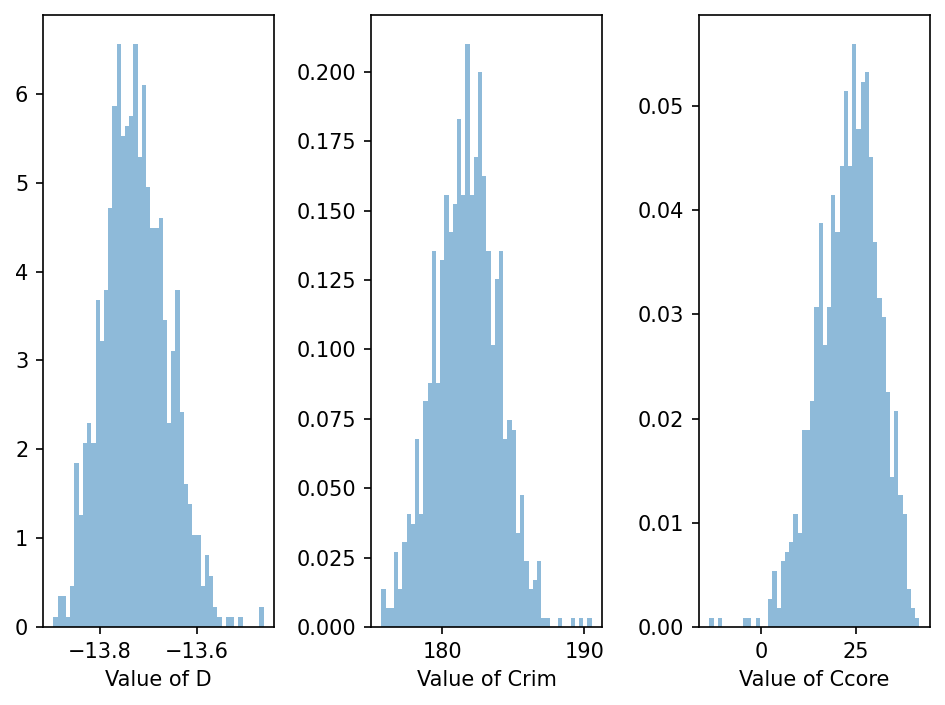

In [54]:
# plotting histograms
plt.figure(dpi=150)
plt.subplot(1,3,1)
plt.hist(popt_array[:,0].ravel(),density=True, bins=50,label="bootstrap", alpha=0.5)
plt.xlabel("Value of D")

plt.subplot(1,3,2)
plt.hist(popt_array[:,1].ravel(), density=True,bins=50,label="bootstrap", alpha=0.5)
plt.xlabel("Value of Crim")

plt.subplot(1,3,3)
plt.hist(popt_array[:,2].ravel(), density=True,bins=50,label="bootstrap", alpha=0.5)
plt.xlabel("Value of Ccore")

plt.tight_layout()

We can do the same with Y values: get their 2.5 and 97.5 percentiles, so we can draw the 95% confidence interval:

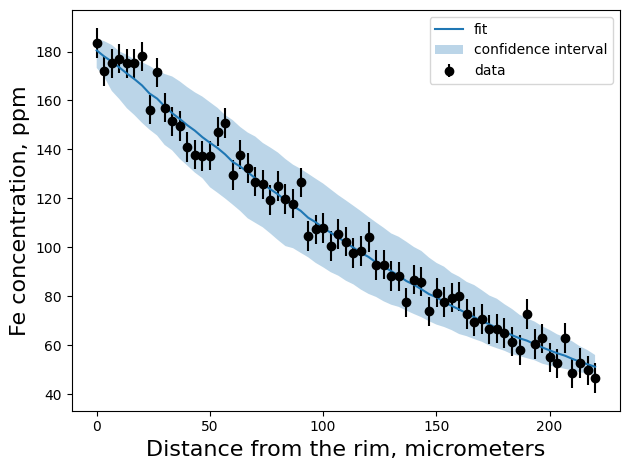

In [56]:
y_low, y_median, y_high = np.percentile(y_calc_array, (2.5, 50., 97.5), axis=0)

plt.figure()
plt.errorbar(x_obs_1, y_obs_1, yerr=ese_obs_1, fmt="ko", label="data")
plt.plot(x_obs_1, y_median, label="fit")
plt.fill_between(x_obs_1, y_low, y_high, alpha=0.3, label="confidence interval")
plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

And we finally check if our confidence intervals are OK. If they are, we should have close to 95% of the data points in the blue area:

In [57]:
# check if 95% of the data points fall within the 2 sigma interval
mask = (y_obs_1 > y_low) & (y_obs_1 < y_high)
print("Fraction of data points within 2 sigma:", np.sum(mask)/len(mask))


Fraction of data points within 2 sigma: 0.9402985074626866


Much better! OK, now you learned how to do bootstrapping and use it to get reliable confidence intervals. Other methods exist, such as MCM, but we got no time to speak about them. Have a look in the Additional Materials folder if you are interested in them. 

A last thing: if you have only three data points with error bars, you will prefer doing parametric bootstrapping. It involves just changing the way you draw the sub datasets: instead of drawing them randomly with replacement, you will draw them from probability distributions over the data.